# C1 W3 Group 8 - Task 3

This notebook begins with an initial *Research* section where various methods were explored to assess their behavior in solving the task at hand. During this exploratory phase, different algorithms and approaches were evaluated to identify the most effective solution.

Following this research, the notebook culminates in a section titled *Final Implementation*. In this part, you'll find the finalized code, which has been simplified and cleaned for clarity and efficiency. This implementation reflects the insights gained from the earlier research, ensuring that it represents the best possible algorithm based on the findings.

# Research

In [1]:
from pathlib import Path
import random
from collections import defaultdict

from src.paths import QSD2_W3_PATH, WEEK_3_RESULTS_PATH
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from skimage import filters

## Parameters

In [2]:
METHOD = "gradient_magnitude"
KERNEL_SIZE = 5
N_MARGIN_COLS = 10
N_MARGIN_ROWS = 10
APPLY_MEDIAN_FILTER = True

## Data loading

In [3]:
query_d2_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W3_PATH.glob("*.jpg"))]  # Load once
query_d2_mask_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W3_PATH.glob("*.png"))]  # Load once

In [4]:
def filter_rgb_image(image: Image) -> Image:
    # Split the image into its RGB channels
    r, g, b = cv2.split(np.array(image))
    
    # Apply median filter to each channel
    r_filtered = cv2.medianBlur(r, 3)
    g_filtered = cv2.medianBlur(g, 3)
    b_filtered = cv2.medianBlur(b, 3)
    
    # Merge the filtered channels back
    return Image.fromarray(cv2.merge([r_filtered, g_filtered, b_filtered]))

In [5]:
if APPLY_MEDIAN_FILTER:
    query_d2_image_PIL_list = [filter_rgb_image(image) for image in query_d2_image_PIL_list]

## Functions

In [6]:
def show_images(images, n_cols: int = 3, output_file: str | Path | None = None):
    # Calculate number of rows needed
    n_rows = (len(images) + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
    
    # Flatten axes array for easier iteration (in case there are multiple rows)
    axes = axes.ravel()
    
    # Loop over the images and display them
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].axis('off')  # Turn off axis labels
    
    # Turn off the remaining axes if there are any
    for idx in range(len(images), n_rows * n_cols):
        axes[idx].axis('off')
    
    plt.tight_layout()
    if output_file is not None:
        plt.savefig(str(output_file), bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [7]:
def show_image_with_mean_values(image_array):
    image_array = np.copy(image_array)
    image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    
    mean_rows = image_array.mean(axis=1)
    mean_cols = image_array.mean(axis=0)
    
    # Calculate thresholds using Otsu's method
    threshold_rows = filters.threshold_otsu(mean_rows)
    threshold_cols = filters.threshold_otsu(mean_cols)

    # Create a figure with subplots
    fig = plt.figure(figsize=(8, 8))
    grid = plt.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0, wspace=0)
    
    # Main image
    ax_image = fig.add_subplot(grid[1, 0])
    ax_image.imshow(image_array, aspect='auto')

    # Plot mean of columns (on the top)
    ax_cols = fig.add_subplot(grid[0, 0], sharex=ax_image)
    ax_cols.plot(np.arange(len(mean_cols)), (mean_cols > threshold_cols), color='black')
    ax_cols.plot(np.arange(len(mean_cols)), mean_cols, color='red')
    ax_cols.axhline(y=threshold_cols, color='green', linestyle='--', label=f'Threshold = {threshold_cols:.2f}')
    ax_cols.set_xticks([])
    ax_cols.set_yticks([0, 0.25, 0.5, 0.75, 1])  # Set ticks for normalized values
    ax_cols.set_yticklabels([0, 0.25, 0.5, 0.75, 1])
    ax_cols.grid(True)  # Add grid

    # Plot mean of rows (on the right)
    ax_rows = fig.add_subplot(grid[1, 1], sharey=ax_image)
    ax_rows.plot((mean_rows > threshold_rows), np.arange(len(mean_rows)), color='black')
    ax_rows.plot(mean_rows, np.arange(len(mean_rows)), color='blue')    
    ax_rows.axvline(x=threshold_rows, color='green', linestyle='--', label=f'Threshold = {threshold_rows:.2f}')
    ax_rows.set_xticks([0, 0.25, 0.5, 0.75, 1])  # Set ticks for normalized values
    ax_rows.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
    ax_rows.set_yticks([])
    ax_rows.grid(True)  # Add grid
    
    plt.show()

In [8]:
def fill_mask(array, side: str):
    # Make a copy
    array = np.copy(array)
    
    # Calculate rows and columns with sufficient non-zero pixel percentage
    mean_rows = (array > 0).mean(axis=1)
    mean_cols = (array > 0).mean(axis=0)
    
    # Calculate thresholds using Otsu's method
    threshold_rows = filters.threshold_otsu(mean_rows)
    threshold_cols = filters.threshold_otsu(mean_cols)

    # Get the indices of valid rows and columns
    y_nonzero_indices = np.nonzero((mean_rows > threshold_rows))[0]
    x_nonzero_indices = np.nonzero((mean_cols > threshold_cols))[0]

    # Get the first and last valid positions
    y_ini, y_end = y_nonzero_indices.min(), y_nonzero_indices.max()
    x_ini, x_end = x_nonzero_indices.min(), x_nonzero_indices.max()
    
    # Special conditions when filling cropped paintings
    # if painting touches right side (left crop)
    if side == "left" and array[(mean_rows > threshold_rows), -1].any():
        x_end = array.shape[1]
    # elif painting touches left side (right crop)
    elif side == "right" and array[(mean_rows > threshold_rows), 0].any():
        x_ini = 0

    # Fill the area between the first and last valid positions with the fill value
    array[y_ini:y_end + 1, x_ini:x_end + 1] = 255
    
    # Set all values outside the indexed range to 0
    array[:y_ini, :] = 0  # Above the valid range
    array[y_end + 1:, :] = 0  # Below the valid range
    array[:, :x_ini] = 0  # Left of the valid range
    array[:, x_end + 1:] = 0  # Right of the valid range
    
    return array  # Return once filling is done

In [9]:
def apply_otsu_to_image(image: np.ndarray) -> np.ndarray:
    return (image > filters.threshold_otsu(image)).astype(np.uint8) * 255

In [10]:
def get_gradient_magnitude(image: np.ndarray) -> np.ndarray:
    # Define kernels for different edge orientations
    kernely = np.array([
        [1] * KERNEL_SIZE,
        [1] * KERNEL_SIZE, 
        [0] * KERNEL_SIZE, 
        [-1] * KERNEL_SIZE,
        [-1] * KERNEL_SIZE
    ])   # Vertical
    kernelx = np.copy(kernely).T  # Horizontal
    
    # Calculate gradients
    gradient_x = cv2.filter2D(image, cv2.CV_64F, kernelx)
    gradient_y = cv2.filter2D(image, cv2.CV_64F, kernely)
    
    # Calculate gradient magnitudes
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    
    return gradient_magnitude

In [11]:
def get_painting_mask(image: Image, method: str) -> (np.ndarray, np.ndarray):
    if method == "saturation":
        _, S, _ = image.convert("HSV").split()
        S = np.array(S)
        left_S, right_S = S[:, :S.shape[1]//2], S[:, S.shape[1]//2:]
        left_mask, right_mask = apply_otsu_to_image(left_S), apply_otsu_to_image(right_S)
    elif method == "gradient_magnitude":
        L = np.array(image.convert("L"))
        left_L, right_L = L[:, :L.shape[1]//2], L[:, L.shape[1]//2:]
        left_L_gradient_magnitude, right_L_gradient_magnitude = get_gradient_magnitude(left_L), get_gradient_magnitude(right_L)
        left_mask, right_mask = apply_otsu_to_image(left_L_gradient_magnitude), apply_otsu_to_image(right_L_gradient_magnitude)
    else:
        raise RuntimeError(f"Method {method} not supported")
    return left_mask, right_mask

In [12]:
def correct_vertical_transition_in_concatenated_mask(mask: np.ndarray) -> np.ndarray:
    corrected_mask = np.zeros(mask.shape, dtype=np.float32)
    
    nonzero_rows, nonzero_cols = np.nonzero(mask)
    top_left_y = nonzero_rows[nonzero_cols == nonzero_cols.min()].min()
    top_right_y = nonzero_rows[nonzero_cols == nonzero_cols.max()].min()
    bottom_left_y = nonzero_rows[nonzero_cols == nonzero_cols.min()].max()
    bottom_right_y = nonzero_rows[nonzero_cols == nonzero_cols.max()].max()
    
    n_cols_of_linspace = nonzero_cols.max() - nonzero_cols.min()
    
    top_y_linspace = np.linspace(top_left_y, top_right_y, num=n_cols_of_linspace, endpoint=True, dtype=int)
    bottom_y_linspace = np.linspace(bottom_left_y, bottom_right_y, num=n_cols_of_linspace, endpoint=True, dtype=int)
    x_linspace = np.linspace(nonzero_cols.min(), nonzero_cols.max(), num=n_cols_of_linspace, endpoint=True, dtype=int)
    
    for y in range(corrected_mask.shape[0]):
        for idx in range(len(x_linspace)):
            if top_y_linspace[idx] <= y <= bottom_y_linspace[idx]:
                corrected_mask[y, x_linspace[idx]] = 255
    
    return corrected_mask

In [13]:
def fill_painting_mask(mask: np.ndarray, side: str) -> (np.ndarray, np.ndarray, np.ndarray):
    # Fill raw mask
    filled_mask = fill_mask(mask, side)
    
    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    
    # `stats[:, cv2.CC_STAT_AREA]` gives the area of each component.
    areas = stats[1:, cv2.CC_STAT_AREA]  # Ignore background
    indices = np.arange(len(areas))
    
    if side == "left":
        labels[:, :N_MARGIN_COLS] = 0
    elif side == "right":
        labels[:, -N_MARGIN_COLS:] = 0
    labels[:N_MARGIN_ROWS] = 0
    labels[-N_MARGIN_ROWS:] = 0
    
    indices += 1  # Add 1 to correct for the ignored background
    
    largest_components_mask = np.isin(labels, indices).astype(np.uint8) * 255
    filled_largest_components_mask = fill_mask(largest_components_mask, side)
    
    return filled_mask, largest_components_mask, filled_largest_components_mask

In [14]:
def compute_metrics(ground_truth, predicted):
    # Ensure the inputs are numpy arrays
    ground_truth = np.asarray(ground_truth).astype(bool)
    predicted = np.asarray(predicted).astype(bool)
    
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((predicted == 1) & (ground_truth == 1))  # True Positives
    FP = np.sum((predicted == 1) & (ground_truth == 0))  # False Positives
    FN = np.sum((predicted == 0) & (ground_truth == 1))  # False Negatives
    
    # Precision, Recall, F1-score, IoU
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    
    # Create a DataFrame with the metrics for a single mask comparison
    metrics_df = pd.DataFrame({
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1_score],
        'IoU': [iou]
    })
    
    return metrics_df

def compute_average_metrics(ground_truth_list, predicted_list):
    assert len(ground_truth_list) == len(predicted_list), "Lists must have the same length"
    
    metrics_list = []
    
    for gt_mask, pred_mask in zip(ground_truth_list, predicted_list):
        metrics_df = compute_metrics(gt_mask, pred_mask)
        metrics_list.append(metrics_df)
    
    # Concatenate individual DataFrames into one DataFrame
    all_metrics_df = pd.concat(metrics_list, ignore_index=True)
    
    # Calculate the average of each column
    avg_metrics_df = pd.DataFrame(all_metrics_df.mean()).T
    avg_metrics_df.index = ['Average']  # Label the row as 'Average'
    
    return avg_metrics_df

## Background subtraction

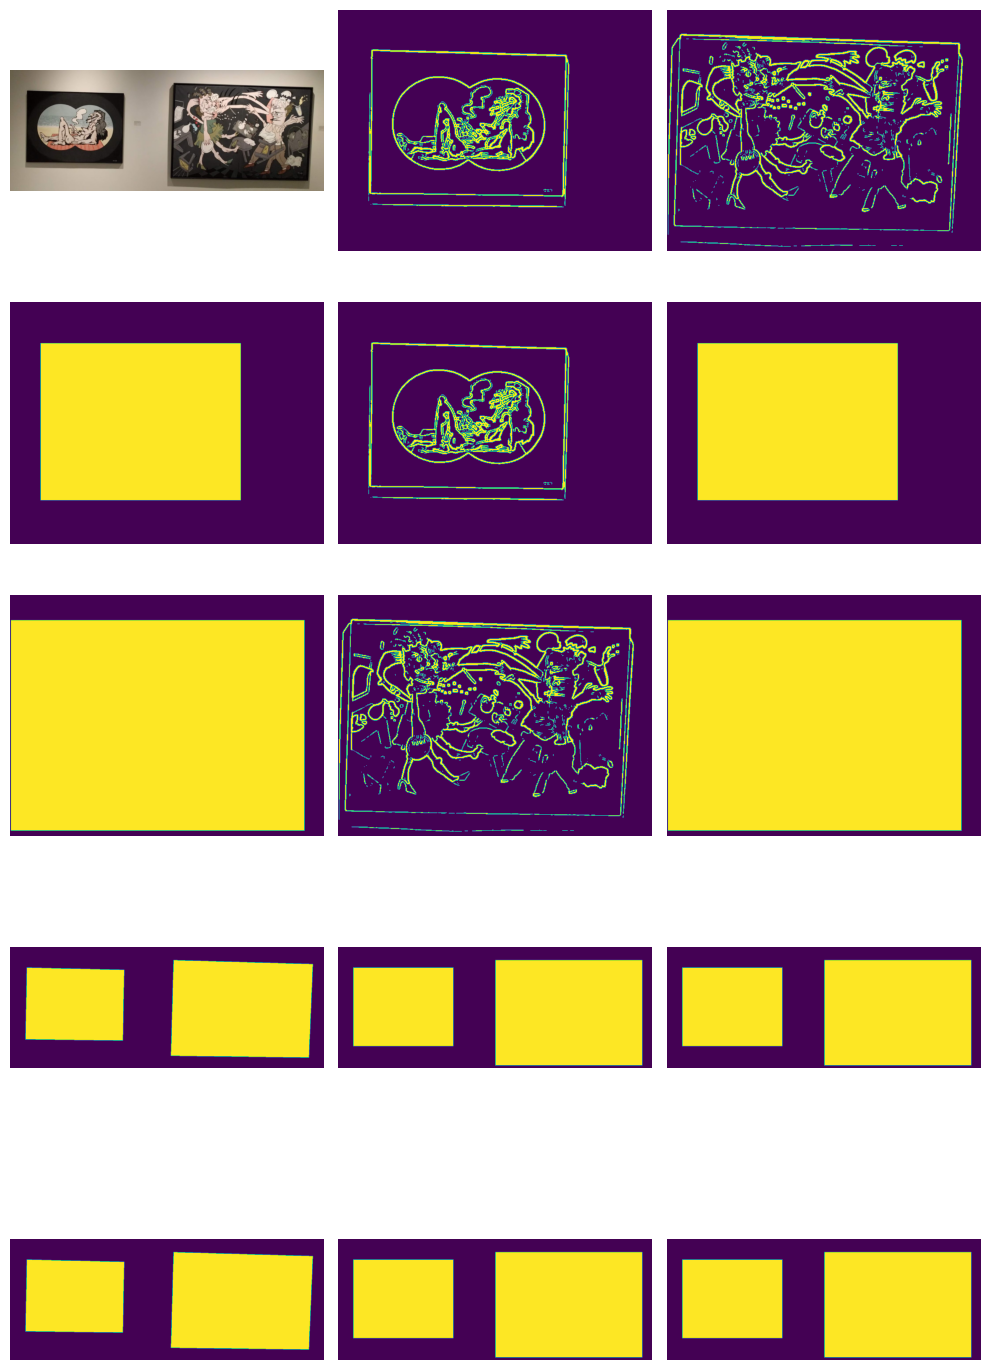

In [15]:
# Parameters
rand_idx = random.randrange(len(query_d2_image_PIL_list))

image = query_d2_image_PIL_list[rand_idx]
gt_mask = query_d2_mask_PIL_list[rand_idx]

left_mask, right_mask = get_painting_mask(image, method=METHOD)

left_filled_mask, left_largest_components_mask, left_filled_largest_components_mask = fill_painting_mask(left_mask, side="left")
right_filled_mask, right_largest_components_mask, right_filled_largest_components_mask = fill_painting_mask(right_mask, side="right")

final_filled_mask = np.concatenate((left_filled_mask, right_filled_mask), axis=1)
final_filled_largest_components_mask = np.concatenate((left_filled_largest_components_mask, right_filled_largest_components_mask), axis=1)

if left_filled_mask[:, -1].any() and right_filled_mask[:, 0].any():
    corrected_final_filled_mask = correct_vertical_transition_in_concatenated_mask(final_filled_mask)
else:
    corrected_final_filled_mask = final_filled_mask

if left_filled_largest_components_mask[:, -1].any() and right_filled_largest_components_mask[:, 0].any():
    corrected_final_filled_largest_components_mask = correct_vertical_transition_in_concatenated_mask(final_filled_largest_components_mask)
else:
    corrected_final_filled_largest_components_mask = final_filled_largest_components_mask

show_images(
    [image, left_mask, right_mask, 
     left_filled_mask, left_largest_components_mask, left_filled_largest_components_mask,
     right_filled_mask, right_largest_components_mask, right_filled_largest_components_mask,
     gt_mask, final_filled_mask, final_filled_largest_components_mask,
     gt_mask, corrected_final_filled_mask, corrected_final_filled_largest_components_mask
    ]
)

In [16]:
# Parameters
mask_output_folder = WEEK_3_RESULTS_PATH / "Task_3" / f"mask_M_{METHOD}_MF_{APPLY_MEDIAN_FILTER}_KS_{KERNEL_SIZE}_NMR_{N_MARGIN_ROWS}_NMC_{N_MARGIN_COLS}"
mask_output_folder.mkdir(parents=True, exist_ok=True)

final_masks = defaultdict(list)
for name, image, gt_mask in zip(sorted(QSD2_W3_PATH.glob("*.jpg")), query_d2_image_PIL_list, query_d2_mask_PIL_list):
    left_mask, right_mask = get_painting_mask(image, method=METHOD)
    
    left_filled_mask, left_largest_components_mask, left_filled_largest_components_mask = fill_painting_mask(left_mask, side="left")
    right_filled_mask, right_largest_components_mask, right_filled_largest_components_mask = fill_painting_mask(right_mask, side="right")
    
    final_filled_mask = np.concatenate((left_filled_mask, right_filled_mask), axis=1)
    final_filled_largest_components_mask = np.concatenate((left_filled_largest_components_mask, right_filled_largest_components_mask), axis=1)
    
    if left_filled_mask[:, -1].any() and right_filled_mask[:, 0].any():
        corrected_final_filled_mask = correct_vertical_transition_in_concatenated_mask(final_filled_mask)
    else:
        corrected_final_filled_mask = final_filled_mask
    
    if left_filled_largest_components_mask[:, -1].any() and right_filled_largest_components_mask[:, 0].any():
        corrected_final_filled_largest_components_mask = correct_vertical_transition_in_concatenated_mask(final_filled_largest_components_mask)
    else:
        corrected_final_filled_largest_components_mask = final_filled_largest_components_mask
    
    show_images(
        [image, left_mask, right_mask, 
         left_filled_mask, left_largest_components_mask, left_filled_largest_components_mask,
         right_filled_mask, right_largest_components_mask, right_filled_largest_components_mask,
         gt_mask, final_filled_mask, final_filled_largest_components_mask,
         gt_mask, corrected_final_filled_mask, corrected_final_filled_largest_components_mask
        ],
        output_file=str(mask_output_folder / f"{name.stem}.png")
    )
    
    final_masks["final_filled_mask"].append(final_filled_mask)
    final_masks["final_filled_largest_components_mask"].append(final_filled_largest_components_mask)
    final_masks["corrected_final_filled_mask"].append(corrected_final_filled_mask)
    final_masks["corrected_final_filled_largest_components_mask"].append(corrected_final_filled_largest_components_mask)

In [17]:
all_avg_metrics_df = pd.DataFrame()
for mask_name, query_background_mask_list in final_masks.items():
    # Compute the average metrics for a list of masks and return a DataFrame
    avg_metrics_df = compute_average_metrics(query_d2_mask_PIL_list, query_background_mask_list)
    
    # To export
    avg_metrics_df["mask_name"] = mask_name
    all_avg_metrics_df = pd.concat([all_avg_metrics_df, avg_metrics_df])

all_avg_metrics_df.to_csv(mask_output_folder / "all_avg_metrics.csv", index=False)

In [18]:
# Worst cases

all_metrics_df = pd.DataFrame()
for i, (gt_mask, pred_mask) in enumerate(zip(query_d2_mask_PIL_list, final_masks["corrected_final_filled_largest_components_mask"])):
    metrics_df = compute_metrics(gt_mask, pred_mask)
    metrics_df["number"] = i
    all_metrics_df = pd.concat([all_metrics_df, metrics_df])
    
all_metrics_df.sort_values(by="F1-score", ascending=True)

,Precision,Recall,F1-score,IoU,number
0,0.810027,0.999454,0.894825,0.809669,29
0,0.861527,1.000000,0.925613,0.861527,11
0,0.885809,0.999079,0.939041,0.885086,6
0,0.900748,0.980751,0.939049,0.885101,0
0,0.913307,0.979022,0.945024,0.895777,22
0,0.915493,0.991640,0.952047,0.908482,20
0,0.910907,1.000000,0.953377,0.910907,4
0,0.920241,0.996315,0.956769,0.917120,2
0,0.920032,0.998034,0.957447,0.918368,17
0,0.926000,0.992189,0.957953,0.919298,19


In [19]:
all_avg_metrics_df

,Precision,Recall,F1-score,IoU,mask_name
Average,0.938587,0.993346,0.964204,0.932426,final_filled_mask
Average,0.944814,0.992681,0.967545,0.938073,final_filled_largest_components_mask
Average,0.939447,0.993029,0.964515,0.932997,corrected_final_filled_mask
Average,0.945635,0.992342,0.967817,0.938580,corrected_final_filled_largest_components_mask


# Final implementation

In [20]:
from tqdm import tqdm
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.background import get_painting_masks
from src.denoising import denoise_image
from src.metrics import compute_average_binary_mask_metrics
from src.paths import QSD2_W3_PATH, WEEK_3_RESULTS_PATH
from src.utils import show_images

In [21]:
query_d2_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W3_PATH.glob("*.jpg"))]  # Load once
query_d2_mask_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W3_PATH.glob("*.png"))]  # Load once

In [22]:
# Apply median filter
query_d2_image_PIL_list = [denoise_image(image) for image in query_d2_image_PIL_list]

In [23]:
# Parameters
mask_output_folder = WEEK_3_RESULTS_PATH / "Task_3" / "final_results"
mask_output_folder.mkdir(parents=True, exist_ok=True)

painting_masks_list = []
pbar = tqdm(zip(sorted(QSD2_W3_PATH.glob("*.jpg")), query_d2_image_PIL_list, query_d2_mask_PIL_list))
for name, image, gt_mask in pbar:
    pbar.set_description(f"Processing {name.stem}")
    painting_masks = get_painting_masks(image)
    
    show_images(
        [image, gt_mask, painting_masks],
        output_file=str(mask_output_folder / f"{name.stem}.png")
    )
    
    painting_masks_list.append(painting_masks)

Processing 00029: : 30it [00:16,  1.79it/s]


In [24]:
# Compute the average metrics for a list of masks and return a DataFrame
avg_metrics_df = compute_average_binary_mask_metrics(
    ground_truth_list=query_d2_mask_PIL_list,
    predicted_list=painting_masks_list
)
avg_metrics_df

,Precision,Recall,F1-score,IoU
Average,0.943527,0.992343,0.966651,0.936502
